In [1]:
import collections
import datetime
import glob
import random
import time

import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt

from data.load_data import *

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

seed = 2022
tf.random.set_seed(seed)
np.random.seed(seed)

Num GPUs Available:  1


In [2]:
print("Loading data...")
dataset = load_pitch_data(use_cache=True).reshape((1_406_848, 1))[:640_000]
print(f">> {dataset.shape}")
note_count = len(dataset)

Loading data...
>> (640000, 1)


In [3]:
print("Creating tensorflow dataset...")
notes_dataset = tf.data.Dataset.from_tensor_slices(dataset)
print(f">> {notes_dataset.element_spec}")

Creating tensorflow dataset...
>> TensorSpec(shape=(1,), dtype=tf.int32, name=None)


In [4]:
def create_sequences(dataset: tf.data.Dataset, seq_length: int, vocab_size=128) -> tf.data.Dataset:
    """ Returns TF Dataset of sequence and label examples """
    seq_length = seq_length + 1

    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)

    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalize note pitch
    def scale_pitch(x):
        return x / vocab_size

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key: labels_dense[i] for i, key in enumerate(["pitch"])}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)


seq_length = 64
vocab_size = 128  # range of pitches supported in pretty_midi
sequence_dataset = create_sequences(notes_dataset, seq_length, vocab_size)
print(sequence_dataset.element_spec)

(TensorSpec(shape=(64, 1), dtype=tf.float64, name=None), {'pitch': TensorSpec(shape=(), dtype=tf.int32, name=None)})


In [5]:
for seq, target in sequence_dataset.take(1):
    print('sequence shape:', seq.shape)
    print('sequence elements (first 5):', seq[0: 5])
    print('target:', target)

sequence shape: (64, 1)
sequence elements (first 5): tf.Tensor(
[[0.5390625]
 [0.5078125]
 [0.5546875]
 [0.5      ]
 [0.5390625]], shape=(5, 1), dtype=float64)
target: {'pitch': <tf.Tensor: shape=(), dtype=int32, numpy=72>}


In [22]:
batch_size = 512
buffer_size = note_count - seq_length  # the number of items in the dataset
train_dataset = (sequence_dataset
                 .shuffle(buffer_size)
                 .batch(batch_size, drop_remainder=True)
                 .cache()
                 .prefetch(tf.data.experimental.AUTOTUNE))

In [23]:
input_shape = (seq_length, 1)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(512)(inputs)

outputs = {
    'pitch': tf.keras.layers.Dense(128, name='pitch')(x)
}

model = tf.keras.Model(inputs, outputs)

loss = {
    'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 1)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 512)               1052672   
                                                                 
 pitch (Dense)               (None, 128)               65664     
                                                                 
Total params: 1,118,336
Trainable params: 1,118,336
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.evaluate(train_dataset, return_dict=True)

1249/1249 [==============================] - 70s 14ms/step - loss: 4.8535


{'loss': 4.8535332679748535}

In [25]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="./training_checkpoints/ckpt_{epoch}",
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True)
]

In [26]:
epochs = 50
history = model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
1249/1249 [==============================] - 46s 36ms/step - loss: 3.8389
Epoch 2/50
1249/1249 [==============================] - 47s 38ms/step - loss: 3.6576
Epoch 3/50
1249/1249 [==============================] - 46s 37ms/step - loss: 3.4878
Epoch 4/50
1249/1249 [==============================] - 49s 39ms/step - loss: 3.3635
Epoch 5/50
1249/1249 [==============================] - 50s 40ms/step - loss: 3.2687
Epoch 6/50
1249/1249 [==============================] - 46s 37ms/step - loss: 3.1897
Epoch 7/50
1249/1249 [==============================] - 46s 37ms/step - loss: 3.1605
Epoch 8/50
1249/1249 [==============================] - 46s 37ms/step - loss: 3.0444
Epoch 9/50
1249/1249 [==============================] - 47s 37ms/step - loss: 2.9780
Epoch 10/50
1249/1249 [==============================] - 47s 37ms/step - loss: 3.0589
Epoch 11/50
1249/1249 [==============================] - 47s 37ms/step - loss: 2.9035
Epoch 12/50
1249/1249 [==============================] - 47s 37

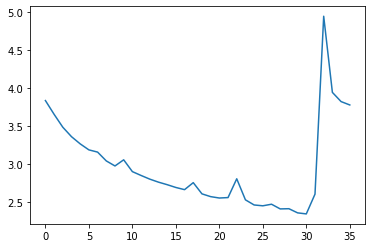

In [27]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [28]:
def predict_next_note(notes: np.ndarray, model: tf.keras.Model, temperature=1.0) -> int:
    """Generates a note IDs using a trained sequence model."""
    assert temperature > 0
    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)
    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    return int(pitch)

In [54]:
temperature = 3.0
num_predictions = 500

a = random.randint(0, 6000)
print(f"Using starter notes from {a} to {a + 64}...")
sample_notes = np.stack(dataset[a:a + 64])
input_notes = (sample_notes[:seq_length] / np.array([vocab_size]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
    pitch = predict_next_note(input_notes, model, temperature)
    start = prev_start + 0.1
    end = start + random.random()
    input_note = (pitch,)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, axis=0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(generated_notes, columns=("pitch", "start", "end"))

Using starter notes from 566 to 630...


In [55]:
def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name="Acoustic Grand Piano") -> pretty_midi.PrettyMIDI:
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program(instrument_name))

    for i, note in notes.iterrows():
        print(note)
        n = pretty_midi.Note(
            velocity=random.randint(80, 120),
            pitch=int(note["pitch"]),
            start=note["start"],
            end=note["end"],
        )
        instrument.notes.append(n)

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

In [56]:
out_file = f"../output/{int(time.time())}.mid"
out_pm = notes_to_midi(generated_notes, out_file=out_file)

pitch    57.000000
start     0.100000
end       0.142801
Name: 0, dtype: float64
pitch    81.000000
start     0.200000
end       0.907441
Name: 1, dtype: float64
pitch    81.000000
start     0.300000
end       0.885187
Name: 2, dtype: float64
pitch    81.000000
start     0.400000
end       1.030743
Name: 3, dtype: float64
pitch    79.000000
start     0.500000
end       0.795226
Name: 4, dtype: float64
pitch    84.000000
start     0.600000
end       1.112897
Name: 5, dtype: float64
pitch    81.00000
start     0.70000
end       1.45851
Name: 6, dtype: float64
pitch    81.000000
start     0.800000
end       1.392707
Name: 7, dtype: float64
pitch    83.000000
start     0.900000
end       1.140715
Name: 8, dtype: float64
pitch    103.000000
start      1.000000
end        1.392184
Name: 9, dtype: float64
pitch    81.0000
start     1.1000
end       1.2858
Name: 10, dtype: float64
pitch    81.000000
start     1.200000
end       1.774878
Name: 11, dtype: float64
pitch    75.00000
start     1.30

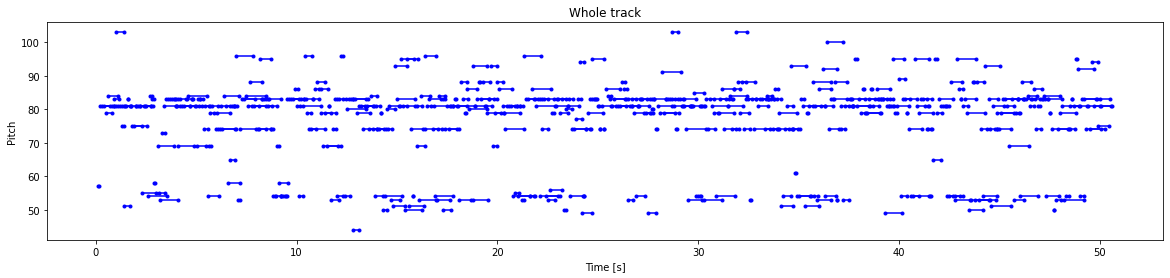

In [57]:
def plot_piano_roll(notes: pd.DataFrame, count=None):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(
        plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)


plot_piano_roll(generated_notes)